# Quick 20 minute (ish) PyTorch Demo using Jupyter Notebooks


### I'll cover:

* some nifty features (some of which I wish I had discovered earlier) of Jupyter Notebooks
* what PyTorch is, and what problems it tries to solve in general
* the most common hiccup I ran into when learning PyTorch
* using PyTorch to model generated example data first with simple linear regression, then with a minimal-sized neural network


## Some quick Jupyter Notebooks features

### 1) You can install packages right from the notebook
(in other words, you don't have to shut the kernel down, install it, and then restart it)

In [1]:
import sys

# Anaconda
!conda install --yes --prefix {sys.prefix} <Package Name>

# pip
!{sys.executable} -m pip install <Package Name>

# --yes : automatically answer yes to confirmations
# --prefix {sys.prefix} : makes certain that conda installs the package in the currently-running Jupyter kernel
# {sys.executable} -m : makes certain that pip installs the package in the currently-running Jupyter kernel

### 2) You can extend jupyter's auto-print functionality to work multiple times in one cell

In [1]:
ex1 = "Example 1"
ex2 = "Example 2"
ex1
ex2

'Example 2'

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
ex1 = "Example 1"
ex2 = "Example 2"
ex1
ex2

'Example 1'

'Example 2'

### 3) You can make it auto-reload any changes to python files (no restart necessary)

In [3]:
%load_ext autoreload
%autoreload 2

```from foo import some_function```

In [1]: ```some_function()```

Out[1]: 42

#### Now, if you open foo.py in an editor and change some_function to return 43...

In [2]: ```some_function()```

Out[2]: 43

### 4) You can make any matplotlib plots you create be displayed inline with the notebook

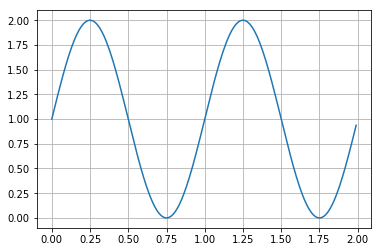

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2*np.pi*t)
plt.plot(t, s)

plt.grid(True)
plt.show()

### 5) You can also make it autosave your work every n seconds

In [10]:
%autosave 30

Autosaving every 30 seconds


### 6) It's also got lots of great keyboard shortcuts

#### Command palette (for those who hate clicking):  CMD + Shift + P
(might be CTRL + Shift + P or something on Windows)

#### Esc     -   command mode (navigation)

#### Enter  -   edit mode (typing)

#### D + D (press twice) to delete current cell

#### Shift + Tab   -   brings up the docstring for the object to the left of your cursor

#### Esc + O   -  toggle cell output

#### J, K   -   move up and down with vim commands

#### l (in command mode)    -   show line numbers

## Anyhow, back to PyTorch...

Let's make some uniformly random data based on the line y = -0.5x + 2

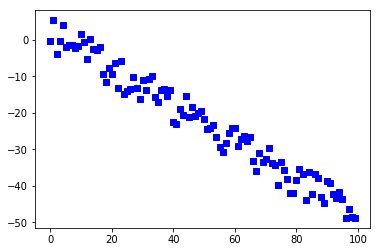

In [7]:
import matplotlib.pyplot as plt
import numpy as np

NUM_DATA_POINTS = 100

x = np.arange(NUM_DATA_POINTS) # create a an array: [0, 1, 2... NUM_DATA_POINTS]
noise = np.random.uniform(-5,5, size=(NUM_DATA_POINTS,)) # create some noise to add to a truly straight line
y = -0.5 * x + 2 + noise # create a straight line plus some noise

axes = plt.gca()
line, = axes.plot(list(x), list(y), 'bs')

## Great, we have data. Looks like using simple linear regression to model it is fair game.

In [11]:
# Data setup:

RATIO_FOR_TESTING = 0.2

test_data_amount     = int(RATIO_FOR_TESTING * NUM_DATA_POINTS) # designate some data for testing
training_data_amount = NUM_DATA_POINTS - test_data_amount # and some for training

all_data_indices = [i for i in range(NUM_DATA_POINTS)]
# this is all the "x" part of the data: 0 through NUM_DATA_POINTS - 1

x_test  = np.random.choice(all_data_indices, test_data_amount, replace=False)
y_test  = [y[i] for i in x_test]
# allocate 20% of data for testing

x_train = list(set(all_data_indices).difference(set(x_test)))
y_train = [y[i] for i in x_train]
# and 80% for training

NameError: name 'NUM_DATA_POINTS' is not defined

### Enter: PyTorch

In [12]:
import torch
from torch.autograd import Variable

# First, we convert our data into tensor form.

x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)

# Then, we wrap the tensors in Variable classes to add extra functionality (that we'll see later)

x_train_var = Variable(x_train) 
x_test_var = Variable(x_test)

ImportError: No module named 'torch'

### Arrays are 1-dimensional, matrices are 2-dimensional, tensors are 3 (and beyond)-dimensional.

In fact, you could say that arrays and matrices are also a more specific form of a tensor.

In [13]:
# Let's look at our variables:

x_test_var
len(x_test_var)

x_train_var
len(x_train_var)

NameError: name 'x_test_var' is not defined

## Awesome. Now let's actually make the linear regression model.

#### Quick linear regression review:

The line we're creating is:

y = mx + b

We have the data (the x's and the y's).

We want to know what the m and b are such that the line fits the data the best.

For now, let's just make an arbitrary line with PyTorch:

In [9]:
import torch.nn as nn
# PyTorch's Neural Network package

line_model = nn.Linear(1, 1)
# this creates a line with 1 "slope" (i.e. weight) and 1 intercept (i.e. bias)

line_model

Linear(in_features=1, out_features=1, bias=True)

We can actually make it with as many weights and as many outputs as we want.

#### But what are m and be right now, exactly?

In [10]:
list(line_model.parameters())

[Parameter containing:
 tensor([[-0.5528]], requires_grad=True), Parameter containing:
 tensor([0.2260], requires_grad=True)]

Note: These are randomly generated.

#### Ok, how do we make it into a line we want (that fits our data)?

In [11]:
test_input = Variable(torch.Tensor(x_test_var))
line_model(test_input)

RuntimeError: size mismatch, m1: [1 x 20], m2: [1 x 1] at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/TH/generic/THTensorMath.cpp:2070

## Aaaaaaand crash and burn. Tensors can be tricky. What's going on here?

### What we wanted to do:

- Take the x values of our test data (which was literally just the indices earlier)
- Run all those values through our line, one at a time (i.e. put an x in, get a y, repeat 20 times)
- See the results

### What PyTorch thought we wanted to do:

- Take all the x values of our test data
- Fit all the x's into the line at once, as though our line had 20 inputs

But our line only has one input. What's the solution?

### Answer:

Reshape our tensor.

In [12]:
test_input = Variable(torch.Tensor(x_test_var))
"BEFORE"
test_input
"AFTER"
test_input.view(-1, 1)

'BEFORE'

tensor([27., 65., 79., 61., 75., 34.,  3., 40., 99., 52., 56., 48., 19., 82.,
        16., 60., 86., 92., 41., 30.])

'AFTER'

tensor([[27.],
        [65.],
        [79.],
        [61.],
        [75.],
        [34.],
        [ 3.],
        [40.],
        [99.],
        [52.],
        [56.],
        [48.],
        [19.],
        [82.],
        [16.],
        [60.],
        [86.],
        [92.],
        [41.],
        [30.]])

### Awesome, now it's 20 x 1 shaped instead of 1 x 20 shaped. Let's run it through the model.

In [13]:
line_model(test_input.view(-1, 1)) 

tensor([[-14.6997],
        [-35.7063],
        [-43.4456],
        [-33.4951],
        [-41.2344],
        [-18.5694],
        [ -1.4324],
        [-21.8862],
        [-54.5017],
        [-28.5199],
        [-30.7311],
        [-26.3087],
        [-10.2773],
        [-45.1040],
        [ -8.6189],
        [-32.9423],
        [-47.3153],
        [-50.6321],
        [-22.4390],
        [-16.3582]], grad_fn=<ThAddmmBackward>)

It works!

## Making lines is hard.

What are we doing again?

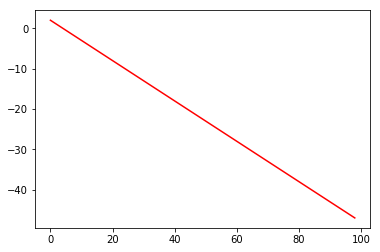

In [14]:
axes = plt.gca()
line, = axes.plot(list(x_train), [-0.5 * x + 2 for x in list(x_train)], 'r-')
plt.show()

### Above: The line we're trying to recreate (we're pretending we don't know that relationship exists)

### Below: The data we're using to recreate the line above.

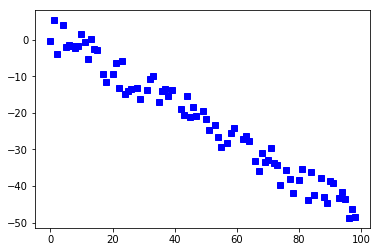

In [15]:
axes = plt.gca()
line, = axes.plot(list(x_train), list(y_train), 'bs')
plt.show()

### Our line currently:

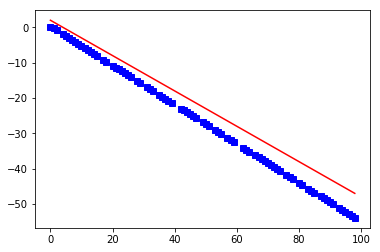

In [16]:
axes = plt.gca()
line, = axes.plot(list(x_train), [-0.5 * x + 2 for x in list(x_train)], 'r-')
line, = axes.plot(list(x_train), list(line_model(x_train.view(-1, 1))), 'bs')
plt.show()

### Okay, so we're a little off. How do we fix it?

### Answer: Some kind of optimization using some loss function. Let's bring in the big guns from PyTorch.

In [17]:
import torch.optim as optim # Optimization package

NUMBER_OF_EPOCHS = 30000       # Number of times to adjust our model
LEARNING_RATE = 1e-2           # How quickly our model "learns"
loss_function = nn.MSELoss()   # The loss function we use. In this case, Mean Squared Error (since it's Linear Regression)
optimizer = optim.SGD(line_model.parameters(), lr=LEARNING_RATE) # The optimizer: Stochastic Gradient Descent

y_train_var = Variable(torch.Tensor(y_train)).view(-1, 1) # again, making our labels into a form usable by PyTorch

for epoch in range(NUMBER_OF_EPOCHS):
    line_model.zero_grad()                       # discard any gradient we used earlier
    output = line_model(x_train_var.view(-1, 1)) # get our output from the model
    loss = loss_function(output, y_train_var)    # calculate the loss
    loss.backward()                              # calculate all the partial derivatives wrt to the loss function
    optimizer.step()                             # add or subtract a portion of the derivatives from each weight



In [18]:
list(line_model.parameters())
# should be -0.5 and 2 (ish)

[Parameter containing:
 tensor([[-0.4958]], requires_grad=True), Parameter containing:
 tensor([2.0268], requires_grad=True)]

### What's it look like now?

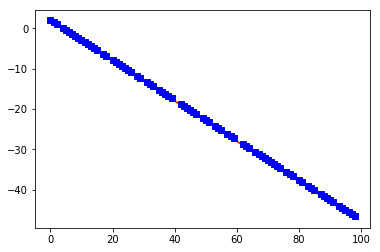

In [19]:
axes = plt.gca()
line, = axes.plot(list(x_train), [-0.5 * x + 2 for x in list(x_train)], 'r-')
line, = axes.plot(list(x_train), list(line_model(x_train.view(-1, 1))), 'bs')
plt.show()

## Yeah, yeah, enough with the lines, I came here for the neural networks!

Ok fine. Here's a demo for that:

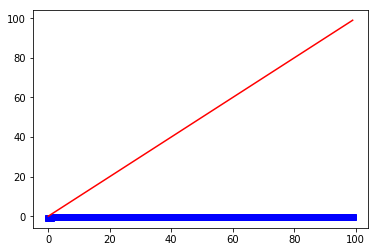

In [20]:
x_train = Variable(torch.Tensor([[i] for i in range(100)]), requires_grad=False)
y_train = Variable(torch.Tensor([[i] for i in range(100)]), requires_grad=False)

# This time, we're approximating y = x with a neural network
# I'm generating 100 data points: (0, 0), (1, 1), ... (99, 99)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

net = Net()
# we made a blueprint above for our neural network, now we initialize one.

#### Red: The identity function: y = x (what we're trying to approximate now)
#### Blue: What our neural network predicts now

In [ ]:
axes = plt.gca()
line, = axes.plot(list(x_train), list(net(x_train)), 'bs')
line, = axes.plot(list(x_train), list(x_train), 'r-')
plt.show()

## So that's kind of bad. How do we train it?

A solution: basically the same thing we did last time.

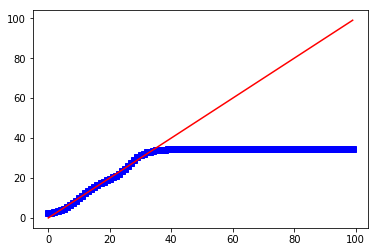

In [21]:
NUMBER_OF_EPOCHS = 10000
LEARNING_RATE = 0.1
loss_function = nn.MSELoss()
optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE) 

import pylab as pl
from IPython import display

for epoch in range(NUMBER_OF_EPOCHS):
    net.zero_grad()
    output = net(x_train)
    loss = loss_function(output, y_train)
    loss.backward()
    optimizer.step()
    
    display.clear_output(wait=True)
    axes = plt.gca()
    line, = axes.plot(list(x_train), list(net(x_train)), 'bs')
    line, = axes.plot(list(x_train), list(x_train), 'r-')
    plt.show()

It's (kind of) learning what y = x is!

# And that's it!